# Marriage and children, but not childless dating or cohabitation, may be immediately competitive with close friendships

In [710]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import statsmodels.api as sm

c = pd.read_table('w4inhome_dvn.tab').rename(columns={'BIO_SEX4': 'gender', 
                                                      'H4EC2': 'income', 
                                                      'H4EC19': 'step',
                                                      'H4ED2': 'education', 
                                                      'H4PE17': 'gregarious', 
                                                      'H4PE25': 'background',
                                                      'H4WGT': 'weight',
                                                      'H4HGT': 'height',
                                                      'H4PR': 'pulse',
                                                      'H4TR1': 'marriages',
                                                      'H4TR9': 'pregnancies', 
                                                      'H4TR10': 'births',
                                                      'H4MH24': 'happiness',
                                                      'H4WS4': 'friends'})
c = pd.concat([pd.read_table('w4weight.tab').drop('AID', axis=1), c], axis=1).sort_index() # read in weights
c = c[c.friends < 6]
c = pd.concat([pd.read_table('w1inhome_dvn.tab', index_col='AID', 
                         usecols=['AID','H1GI4']).loc[c.AID], c.set_index('AID')], axis=1).reset_index() # read in Hispanic origin

In [874]:
def nfriends(friends):
    if friends==1:
        return 0
    elif friends==2:
        return 1.5 #np.random.choice([1,2])
    elif friends==3:
        return 4 #np.random.choice([3,4,5])
    elif friends==4:
        return 7.5 #np.random.choice([6,7,8,9])
    elif friends==5:
        return 10
    
def currentrelationshipyears(row):
    if row.currentrelationshipstatus == 'single':
        return 0
    else:
        return (row.H4RD2Y < 90) * row.H4RD2Y + (row.H4RD2M < 90) * row.H4RD2M/12 + (row.H4RD2D < 90) * row.H4RD2D/365

def currentrelationshipstatus(row):
    try:
        q = p[(p.AID == row.AID) & (p.PTNR_ID == row.PTNR_ID)].iloc[0]
    except IndexError:
        return 'single'
    if q.H4TR14 == 1:
        if q.H4TR13 == 1:
            return 'married'
        elif q.H4TR13 == 2:
            return 'cohabit'
        elif q.H4TR13 == 3:
            return 'pregnant'
    elif q.H4TR13 == 4:
        return 'dating'
    else:
        return 'single'
    
def youngestchildage(row):
    try:
        r = b[b.AID == row.AID]
    except IndexError:
        return np.nan
    if r.H4KK1.min() < 90:
        return r.H4KK1.min()
    else:
        return np.nan

def oldestchildage(row):
    try:
        r = b[b.AID == row.AID]
    except IndexError:
        return np.nan
    return r.H4KK1[r.H4KK1 < 90].max()

def race(code):
    if code == 1 or code == '.':
        return 'white'
    elif code == 2:
        return 'black'
    elif code == 3:
        return 'indian'
    elif code == 4:
        return 'zasian'

In [583]:
p = pd.read_table('w4partner_dvn.tab')
b = pd.read_table('w4child_dvn.tab')

In [875]:
c['nfriends'] = c.friends.apply(nfriends)
c['currentrelationshipstatus'] = c.apply(currentrelationshipstatus, axis=1)
c['currentrelationshipyears'] = c.apply(currentrelationshipyears, axis=1)
c['youngestchildage'] = c.apply(youngestchildage, axis=1)
c['oldestchildage'] = c.apply(oldestchildage, axis=1)
c['race'] = c.H4IR4.apply(race)
c['ishispanic'] = c.H1GI4.apply(lambda x: x==1)

In [928]:
c.friends.value_counts(normalize=True)

3    0.457758
2    0.221279
4    0.169957
5    0.122385
1    0.028622
Name: friends, dtype: float64

In [945]:
np.average(c.nfriends,weights=c.freq_weights)

4.6842104462177083

In [944]:
c.groupby('friends').agg({'freq_weights': 'sum'})/c['freq_weights'].sum()

,freq_weights
friends,
1,0.030200
2,0.219288
3,0.454769
4,0.168493
5,0.127251


In [427]:
columns = list(c.columns)
columns.remove('friends')
columns.remove('H4WS5')
columns.remove('H4LM8')
columns.remove('H4LM18')
columns.remove('VERSION4')
columns.remove('BREAK_Q')
columns.remove('GSWGT4_2')
columns.remove('GSWGT4')
columns.remove('GSWGT134')
columns.remove('CLUSTER2')
columns.remove('freq_weights')
try:
    columns.remove('prediction')
except ValueError:
    pass
columns.remove('AID')

In [575]:
c.age.loc[0]

32.0

In [572]:
c.age.loc[0]

nan

In [574]:
c.age.loc[0] = 32

C:\Users\WeiZhong\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [714]:
c['freq_weights'] = c['GSWGT4_2']/sum(c['GSWGT4_2'])*len(c['GSWGT4_2'])

c['age'] = 2008 - c.H4OD1Y
c['income'][c.income > 1000000] = 35126
c['step'][c.step > 90] = c.step[c.step <= 90].mean()
c['gregarious'][c.gregarious > 5] = c.gregarious[c.gregarious <= 5].mean()
c['gregarious'][c.gregarious.isnull()] = c.gregarious[c.gregarious <= 5].mean()
c['background'][c.background > 5] = c.background[c.background <= 5].mean()
c['background'][c.background.isnull()] = c.background[c.background <= 5].mean()
c['education'][c.education > 90] = c.education[c.education <= 90].mean()
c['height'][c.height > 900] = c.height[c.height <= 900].mean()
c['weight'][c.weight > 900] = c.weight[c.weight <= 900].mean()
c['pulse'][c.pulse > 800] = c.pulse[c.pulse <= 800].mean()
c['marriages'][c.marriages > 5] = c.marriages[c.marriages <= 5].mean()
c['pregnanciesraw'] = c['pregnancies']
c['pregnanciesraw'][c.pregnanciesraw > 90] = np.nan
c['pregnancies'][c.pregnancies > 90] = c.pregnancies[c.pregnancies <= 90].mean()
c['births'][c.births > 90] = 0
c['fetusdeaths'] = (c.pregnanciesraw - c.births).clip(0)
c['fetusdeaths'][c.fetusdeaths.isnull()] = c.fetusdeaths[c.fetusdeaths.notnull()].mean()
c['happiness'][c.happiness > 5] = c.happiness[c.happiness <= 5].mean()

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

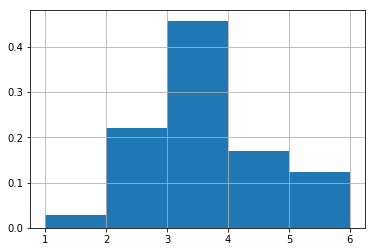

In [184]:
c['friends'].hist(bins=[1,2,3,4,5,6], normed=True)
plt.show()

In [231]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(c.index)

In [428]:
c.fillna(-1, inplace=True)

from sklearn.ensemble import RandomForestRegressor

cls = RandomForestRegressor(n_estimators = 200, n_jobs = -1,
                                     max_features = 30, min_samples_leaf = 2) # No. of estimators should be 50
cls.fit(c.loc[train][columns], c.loc[train].friends, sample_weight=c.loc[train].freq_weights)
c['prediction'] = cls.predict(c[columns])

print('train')
print(np.sqrt(mean_squared_error(c.friends.loc[train], c.prediction.loc[train])))
print('test')
print(np.sqrt(mean_squared_error(c.friends.loc[test], c.prediction.loc[test])))

train
0.439355671318
test
0.91598846245


In [429]:
df_feature_importances = pd.DataFrame(np.transpose([columns, cls.feature_importances_]))
df_feature_importances[1] = df_feature_importances[1].astype(float)
df_feature_importances.sort_values(1, ascending=False).head(n=30)

,0,1
837,gregarious,0.010091
845,background,0.009521
350,income,0.008487
261,education,0.008005
367,step,0.007893
289,H4ED9,0.005924
270,H4ED4A,0.005856
809,H4DA17,0.005633
868,H4SBP,0.005548
876,weight,0.005506


In [329]:
# Talk to different people at parties
c.groupby('friends').pregnancies.describe()

,count,mean,std,min,25%,50%,75%,max
friends,,,,,,,,
1,145.0,2.098247,1.858961,0.0,0.0,2.0,3.0,9.0
2,1121.0,1.846112,1.677718,0.0,0.0,2.0,3.0,10.0
3,2319.0,1.398513,1.563088,0.0,0.0,1.0,2.0,12.0
4,861.0,1.011900,1.433566,0.0,0.0,0.0,2.0,12.0
5,620.0,1.099453,1.485828,0.0,0.0,0.0,2.0,9.0


In [181]:
sum(c.H4PE17.isnull())

0

In [179]:
c.H4PE17[c.H4PE17.isnull()]

990   NaN
Name: H4PE17, dtype: float64

In [165]:
c.H4EC2.value_counts().sort_index()

0.0         345
1.0           1
2.0           1
3.0           1
4.0           2
5.0           1
7.0           1
10.0          1
20.0          1
24.0          1
25.0          1
32.0          1
34.0          1
42.0          1
44.0          1
50.0          1
55.0          1
60.0          1
70.0          1
82.0          1
95.0          1
100.0         1
175.0         1
200.0         5
206.0         1
230.0         1
250.0         1
300.0         2
350.0         1
434.0         1
           ... 
185000.0      1
187000.0      1
190000.0      1
195000.0      1
200000.0      6
230000.0      1
236000.0      1
250000.0      1
275000.0      1
285000.0      1
300000.0      4
312000.0      1
325000.0      1
350000.0      1
360000.0      1
365000.0      1
375000.0      1
393500.0      1
400000.0      1
415000.0      1
420000.0      1
450000.0      1
470000.0      1
475000.0      1
479000.0      1
480001.0      1
500000.0      1
750000.0      1
800000.0      2
999995.0      2
Name: H4EC2, Length: 388

In [151]:
c.H4PE17[c.H4PE17 <= 5].mean()

2.6200277063130812

In [120]:
ss.mannwhitneyu(c[(c.H4WS4==4) & (c.H4PE17 < 6)].H4PE17, c[(c.H4WS4==5) & (c.H4PE17 < 6)].H4PE17, alternative='two-sided')

MannwhitneyuResult(statistic=308368.0, pvalue=9.5883085064508626e-09)

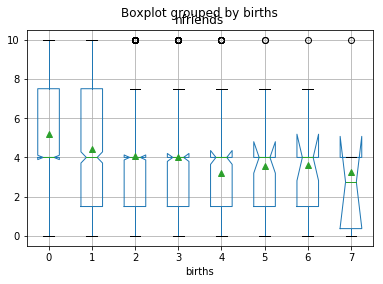

In [626]:
c.boxplot(column='nfriends', by='births', notch=True, showmeans=True)
plt.show()

In [632]:
ss.mannwhitneyu(c[(c.births==2)].nfriends, c[(c.births==3)].nfriends, alternative='two-sided')

MannwhitneyuResult(statistic=182693.5, pvalue=0.46599338221990116)

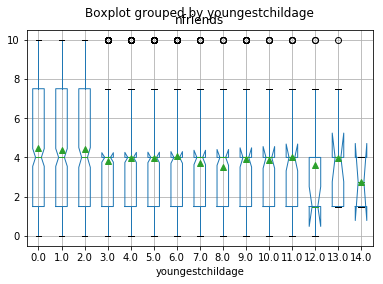

In [625]:
c.boxplot(column='nfriends', by='youngestchildage', notch=True, showmeans=True)
plt.show()

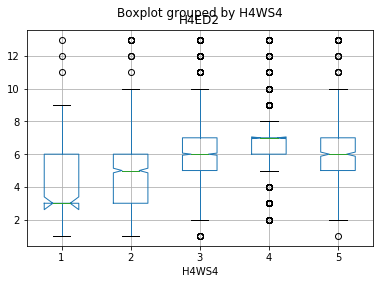

In [73]:
# Educational level
c[c.H4ED2<14].boxplot(column='H4ED2', by='H4WS4', notch=True)
plt.show()

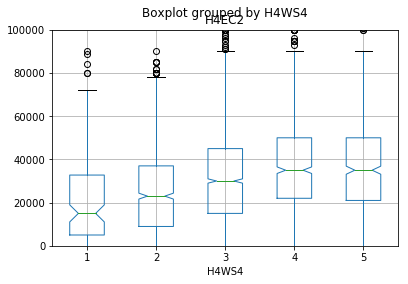

In [78]:
# Income
c[c.H4EC2 < 9999996].boxplot(column='H4EC2', by='H4WS4', notch=True)
plt.ylim([0,100000])
plt.show()

In [455]:
c['currentrelationshipyearsround'] = c.currentrelationshipyears.round()

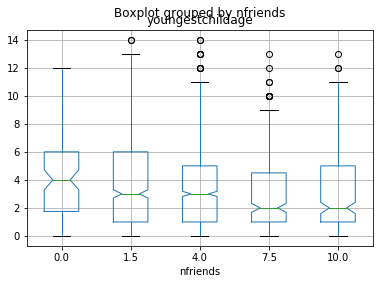

In [600]:
c.boxplot(column='youngestchildage', by='nfriends', notch=True)
plt.show()

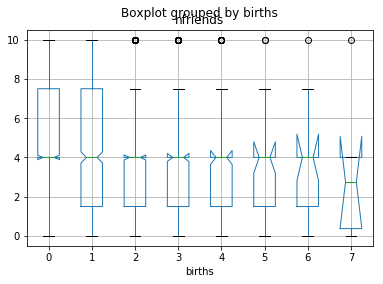

In [773]:
c.boxplot(column='nfriends', by='births', notch=True)
plt.show()

In [353]:
c.groupby('age')['friends'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
25,7.0,2.571429,0.786796,2.0,2.0,2.0,3.0,4.0
26,458.0,3.211790,0.961464,1.0,3.0,3.0,4.0,5.0
27,719.0,3.171071,0.990173,1.0,3.0,3.0,4.0,5.0
28,874.0,3.156751,1.002588,1.0,3.0,3.0,4.0,5.0
29,903.0,3.032115,0.981011,1.0,2.0,3.0,4.0,5.0
30,881.0,3.172531,0.986140,1.0,3.0,3.0,4.0,5.0
31,870.0,3.160920,0.971084,1.0,3.0,3.0,4.0,5.0
32,302.0,3.052980,1.032933,1.0,2.0,3.0,4.0,5.0
33,45.0,2.955556,1.043498,1.0,2.0,3.0,3.0,5.0


In [783]:
ss.mannwhitneyu(c[(c.births==3)].nfriends, c[(c.births>3)].nfriends, alternative='two-sided')

MannwhitneyuResult(statistic=35736.5, pvalue=0.0027139984426471451)

In [343]:
ss.mannwhitneyu(c[(c.friends==3)].marriages, c[(c.friends==4)].marriages, alternative='two-sided')

MannwhitneyuResult(statistic=1049710.0, pvalue=0.011177720705674403)

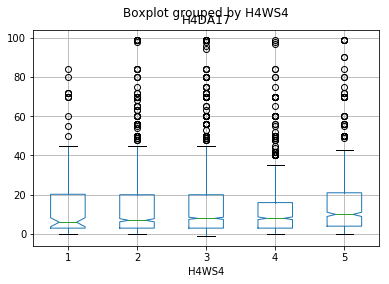

In [94]:
c[c.H4DA17 < 900].boxplot(column='H4DA17', by='H4WS4', notch=True)
plt.show()

In [114]:
ss.mannwhitneyu(c[(c.H4WS4==4) & (c.H4DA17 < 900)].H4DA17, c[(c.H4WS4==5) & (c.H4DA17 < 900)].H4DA17, alternative='two-sided')

MannwhitneyuResult(statistic=228301.5, pvalue=2.2170063275227359e-05)

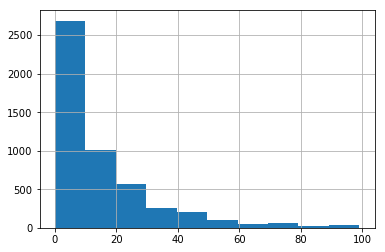

In [104]:
c[c.H4DA17<900].H4DA17.hist()
plt.show()

## Demographic variables

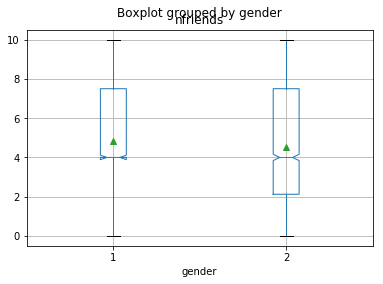

In [653]:
c.boxplot(column='nfriends', by='gender', notch=True, showmeans=True)
plt.show()

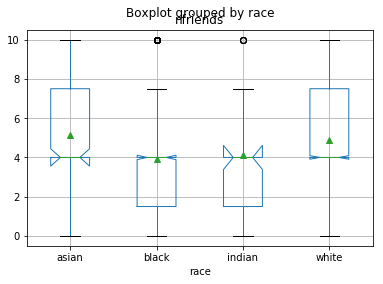

In [654]:
c.boxplot(column='nfriends', by='race', notch=True, showmeans=True)
plt.show()

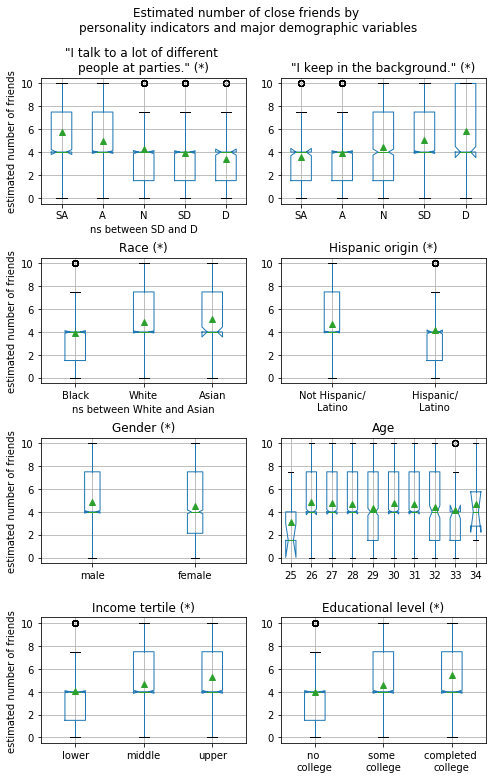

In [921]:
import matplotlib.ticker as plticker


fig = plt.figure(figsize=(7,11))
ax = fig.add_subplot(421)
c[c.gregarious.isin([1,2,3,4,5])].boxplot(column='nfriends', by='gregarious', notch=True, showmeans=True, ax=ax)
plt.title('"I talk to a lot of different \npeople at parties." (*)')
plt.ylabel('estimated number of friends')
ax.xaxis.set_major_locator(plticker.MultipleLocator(1))

plt.xticks([1, 2, 3, 4, 5], ['SA', 'A', 'N', 'SD', 'D'])
#ax.xaxis.get_ticklines()[1].set_visible(False)
plt.xlabel('ns between SD and D')

ax = fig.add_subplot(422)
c[c.background.isin([1,2,3,4,5])].boxplot(column='nfriends', by='background', notch=True, showmeans=True, ax=ax)
plt.title('"I keep in the background." (*)')
plt.xticks([1, 2, 3, 4, 5], ['SA', 'A', 'N', 'SD', 'D'])
plt.xlabel('')

ax = fig.add_subplot(423)
c[c.race != 'indian'].boxplot(column='nfriends', by='race', notch=True, showmeans=True, ax=ax)
plt.title('Race (*)')
plt.ylabel('estimated number of friends')
plt.xticks(range(1,4), ['Black', 'White', 'Asian'])
plt.xlabel('ns between White and Asian')

ax = fig.add_subplot(424)
c.boxplot(column='nfriends', by='ishispanic', notch=True, showmeans=True, ax=ax)
plt.title('Hispanic origin (*)')
plt.xticks(range(1,3), ['Not Hispanic/\nLatino', 'Hispanic/\nLatino'])
plt.xlabel('')


ax = fig.add_subplot(425)
c.boxplot(column='nfriends', by='gender', notch=True, showmeans=True, ax=ax)
plt.xticks(range(1,3), ['male', 'female'])
plt.title('Gender (*)')
plt.ylabel('estimated number of friends')
plt.xlabel('')

ax = fig.add_subplot(426)
c.boxplot(column='nfriends', by='age', notch=True, showmeans=True, ax=ax)
plt.title('Age')
plt.xlabel('')

ax = fig.add_subplot(427)
c['incometertile'] = pd.qcut(c.income, 3, labels=['lower', 'middle', 'upper'])
c.boxplot(column='nfriends', by='incometertile', notch=True, showmeans=True, ax=ax)
plt.title('Income tertile (*)')
plt.xlabel('')
plt.ylabel('estimated number of friends')

ax = fig.add_subplot(428)
c['educationtertile'] = pd.cut(c.education, [0,5,6,14], labels=['no \ncollege', 'some \ncollege', 'completed \ncollege'])
c.boxplot(column='nfriends', by='educationtertile', notch=True, showmeans=True, ax=ax)
plt.title('Educational level (*)')
plt.xlabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.89)
plt.suptitle('Estimated number of close friends by \npersonality indicators and major demographic variables')
plt.savefig('FP F1 Personality and demographics.pdf')
plt.show()

Race - significant interactions btwn black and white, black and asian

Males consider that they have more close friends than females (possibly due to higher income?)

In [916]:
ss.mannwhitneyu(c[(c.background == 1)].friends, c[(c.background == 4)].friends, alternative='two-sided')

MannwhitneyuResult(statistic=106630.5, pvalue=2.9298583885082959e-11)

In [923]:
from statsmodels.formula.api import glm
model = glm('nfriends ~ income + education + gregarious + background + height + fetusdeaths + births  \
            + age + gender + C(race,Treatment("white")) + ishispanic + C(currentrelationshipstatus,Treatment("single")) \
            + currentrelationshipstatus:currentrelationshipyears',
            
               family=sm.families.NegativeBinomial(),
               freq_weights=c.freq_weights,
           data=c) 
results = model.fit()
results.summary()

C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\WeiZhong\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\WeiZhong\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\WeiZhong\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               nfriends   No. Observations:                 5061
Model:                            GLM   Df Residuals:                     5039
Model Family:        NegativeBinomial   Df Model:                           21
Link Function:                    log   Scale:                  0.284457822804
Method:                          IRLS   Log-Likelihood:                -13267.
Date:                Tue, 19 Dec 2017   Deviance:                       1714.3
Time:                        18:57:48   Pearson chi2:                 1.43e+03
No. Iterations:                     6                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         0.9878      0.275      3.593      0.000       0.449       1.527
C(race, Treatment("white"))[T.black]                             -0.1607      0.024     -6.663      0.000      -0.208      -0.113
C(race, Treatment("white"))[T.indian]                             0.0680      0.110      0.620      0.535      -0.147       0.283
C(race, Treatment("white"))[T.zasian]                             0.0094      0.053      0.179      0.858      -0.094       0.113
ishispanic[T.True]                                               -0.0967      0.028     -3.508      0.000      -0.151      -0.043
C(currentrelationshipstatus, Treatment("single"))[T.cohabit]     -0.0200      0.036     -0.556      0.578      -0.090       0.050
C(currentrelationshipstatus, Treatment("single"))[T.dating]       0.0556      0.032      1.717      0.086      -0.008       0.119
C(currentrelationshipstatus, Treatment("single"))[T.married]     -0.1063      0.034     -3.097      0.002      -0.174      -0.039
C(currentrelationshipstatus, Treatment("single"))[T.pregnant]    -0.0197      0.099     -0.199      0.842      -0.213       0.174
income                                                         6.721e-07   1.93e-07      3.476      0.001    2.93e-07    1.05e-06
education                                                         0.0414      0.004     10.189      0.000       0.033       0.049
gregarious                                                       -0.0944      0.009    -10.703      0.000      -0.112      -0.077
background                                                        0.0713      0.010      7.240      0.000       0.052       0.091
height                                                            0.0022      0.001      1.911      0.056   -5.69e-05       0.005
fetusdeaths                                                      -0.0179      0.010     -1.878      0.060      -0.037       0.001
births                                                           -0.0495      0.008     -5.858      0.000      -0.066      -0.033
age                                                               0.0025      0.005      0.528      0.597      -0.007       0.012
gender                                                           -0.0392      0.024     -1.641      0.101      -0.086       0.008
currentrelationshipstatus[cohabit]:currentrelationshipyears      -0.0029      0.006     -0.478      0.632      -0.015       0.009
currentrelationshipstatus[dating]:currentrelationshipyears       -0.0198      0.011     -1.792      0.073      -0.041       0.002
currentrelationshipstatus[married]:currentrelationshipyears       0.0089      0.004      2.461      0.014       0.002       0.016
currentrelationshipstatus[pregnant]:curren

In [942]:
(results.params[1:])

C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


C(race, Treatment("white"))[T.black]                            0.851509
ishispanic[T.True]                                              0.907784
C(currentrelationshipstatus, Treatment("single"))[T.married]    0.899118
income                                                          1.000001
education                                                       1.042282
gregarious                                                      0.909956
background                                                      1.073874
births                                                          0.951703
dtype: float64

In [972]:
pd.DataFrame(results.conf_int().loc['income']*10000).apply(np.exp).rename(index={0: 0.025, 1: 0.975}).T

,0.025,0.975
income,1.002936,1.010566


In [995]:
quantiles = results.conf_int()[multipletests(results.pvalues)[0]].apply(np.exp).rename(columns={0: 0.025, 1: 0.975})[1:]
quantiles.drop('income',inplace=True)
quantiles = pd.concat([pd.DataFrame(results.conf_int().loc['income']*10000).apply(np.exp).rename(index={0: 0.025, 1: 0.975}).T, quantiles])
mean_with_quantiles = pd.concat([pd.DataFrame(results.params[multipletests(results.pvalues)[0]].apply(np.exp)[1:], columns=['mean']), quantiles], axis=1)
mean_with_quantiles.loc['income']['mean'] = np.exp(results.params['income']*10000)
mean_with_quantiles.loc['gregarious'][['mean', 0.025, 0.975]] = 1/mean_with_quantiles.loc['gregarious'][['mean', 0.025, 0.975]]

mean_with_quantiles = mean_with_quantiles.rename(
                    index={'C(currentrelationshipstatus, Treatment("single"))[T.married]': 'being married instead of single',
                           'C(race, Treatment("white"))[T.black]': 'being Black instead of White',
                          'background': 'one-point increase in disagreeing with \n"I keep in the background"',
                          'births': 'every child',
                          'education': 'one-point increase in educational attainment (see caption)',
                          'gregarious': 'one-point increase in agreeing with \n"I talk to a lot of different people at parties"',
                          'income': '10k increase in yearly income',
                          'ishispanic[T.True]': 'being Hispanic'}).sort_values(by='mean',ascending=False)


mean_with_quantiles['lowerror'] = mean_with_quantiles['mean'] - mean_with_quantiles[0.025]
mean_with_quantiles['higherror'] = mean_with_quantiles[0.975] - mean_with_quantiles['mean'] 

C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


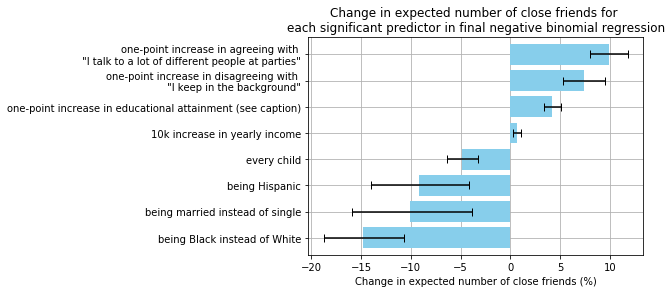

In [1002]:
plt.figure()
change = (mean_with_quantiles['mean'] - 1)*100
#change.loc['one-point decrease in agreeing with "I talk to a lot of different people at parties"'] = - change.loc['one-point decrease in agreeing with "I talk to a lot of different people at parties"']
ax = change.plot.barh(xerr=[(100*mean_with_quantiles[['lowerror', 'higherror']]).values.T], capsize=4, width=0.8, color='skyblue')#, capsize=4, width=0.8, color='#98cc86')
ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=5))
ax.grid()
plt.title('Change in expected number of close friends for \neach significant predictor in final negative binomial regression')
plt.xlabel('Change in expected number of close friends (%)')
ax.invert_yaxis()
plt.savefig('F2 Change in expected number of close friends.pdf', bbox_inches='tight')
plt.show()

In [924]:
pd.DataFrame(np.transpose([multipletests(results.pvalues[1:])[0], multipletests(results.pvalues[1:])[1]]),
             index=results.params.index[1:])

C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


,0,1
"C(race, Treatment(""white""))[T.black]",1.0,5.087297e-10
"C(race, Treatment(""white""))[T.indian]",0.0,9.978235e-01
"C(race, Treatment(""white""))[T.zasian]",0.0,9.993748e-01
ishispanic[T.True],1.0,7.648744e-03
"C(currentrelationshipstatus, Treatment(""single""))[T.cohabit]",0.0,9.978235e-01
"C(currentrelationshipstatus, Treatment(""single""))[T.dating]",0.0,5.927994e-01
"C(currentrelationshipstatus, Treatment(""single""))[T.married]",1.0,2.887816e-02
"C(currentrelationshipstatus, Treatment(""single""))[T.pregnant]",0.0,9.993748e-01
income,1.0,8.101788e-03
education,1.0,0.000000e+00


In [925]:
from statsmodels.formula.api import glm
model2 = glm('nfriends ~ income + education + gregarious + background + fetusdeaths + births\
            + age + gender + C(race,Treatment("white")) + youngestchildage + ishispanic + C(currentrelationshipstatus,Treatment("single"))',
            
               family=sm.families.NegativeBinomial(),
               freq_weights=c.freq_weights,
           data=c) 
results2 = model2.fit()
results2.summary()

C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\WeiZhong\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\WeiZhong\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\WeiZhong\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               nfriends   No. Observations:                 2492
Model:                            GLM   Df Residuals:                     2470
Model Family:        NegativeBinomial   Df Model:                           21
Link Function:                    log   Scale:                  0.325663037075
Method:                          IRLS   Log-Likelihood:                -6270.4
Date:                Tue, 19 Dec 2017   Deviance:                       925.95
Time:                        19:08:18   Pearson chi2:                     805.
No. Iterations:                     6                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.0258      0.243      4.227      0.000       0.550       1.502
C(race, Treatment("white"))[T.black]                             -0.1231      0.036     -3.466      0.001      -0.193      -0.053
C(race, Treatment("white"))[T.indian]                             0.0668      0.160      0.418      0.676      -0.247       0.381
C(race, Treatment("white"))[T.zasian]                            -0.0484      0.097     -0.497      0.619      -0.239       0.143
ishispanic[T.True]                                               -0.0551      0.042     -1.313      0.189      -0.137       0.027
C(currentrelationshipstatus, Treatment("single"))[T.cohabit]     -0.0457      0.062     -0.740      0.459      -0.167       0.075
C(currentrelationshipstatus, Treatment("single"))[T.dating]       0.0702      0.068      1.029      0.303      -0.064       0.204
C(currentrelationshipstatus, Treatment("single"))[T.married]     -0.1071      0.056     -1.913      0.056      -0.217       0.003
C(currentrelationshipstatus, Treatment("single"))[T.pregnant]     0.0505      0.148      0.342      0.732      -0.239       0.340
income                                                         1.365e-06   4.25e-07      3.208      0.001    5.31e-07     2.2e-06
education                                                         0.0368      0.007      5.264      0.000       0.023       0.051
gregarious                                                       -0.1116      0.013     -8.344      0.000      -0.138      -0.085
background                                                        0.0703      0.015      4.588      0.000       0.040       0.100
fetusdeaths                                                      -0.0073      0.014     -0.535      0.593      -0.034       0.019
births                                                           -0.0260      0.015     -1.790      0.073      -0.055       0.002
age                                                               0.0147      0.008      1.898      0.058      -0.000       0.030
gender                                                           -0.0438      0.028     -1.556      0.120      -0.099       0.011
youngestchildage                                                 -0.0140      0.005     -2.886      0.004      -0.024      -0.004
currentrelationshipstatus[cohabit]:currentrelationshipyears       0.0031      0.009      0.368      0.713      -0.014       0.020
currentrelationshipstatus[dating]:currentrelationshipyears       -0.0837      0.025     -3.369      0.001      -0.132      -0.035
currentrelationshipstatus[married]:currentrelationshipyears       0.0108      0.005      2.253      0.024       0.001       0.020
currentrelationshipstatus[pregnant]:curren

In [605]:
np.exp(results.params)

Intercept                                                                2.330599
C(currentrelationshipstatus, Treatment("single"))[T.cohabit]             0.976417
C(currentrelationshipstatus, Treatment("single"))[T.dating]              1.054736
C(currentrelationshipstatus, Treatment("single"))[T.married]             0.902900
C(currentrelationshipstatus, Treatment("single"))[T.pregnant]            1.035754
income                                                                   1.000001
education                                                                1.043816
gregarious                                                               0.908170
background                                                               1.077256
height                                                                   1.002950
fetusdeaths                                                              0.975820
births                                                                   0.946799
C(currentrelatio

In [507]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [926]:
pd.DataFrame(np.transpose([multipletests(results2.pvalues[1:])[0], multipletests(results2.pvalues[1:])[1]]),
             index=results2.params.index[1:])

C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
C:\Users\WeiZhong\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


,0,1
"C(race, Treatment(""white""))[T.black]",1.0,9.978870e-03
"C(race, Treatment(""white""))[T.indian]",0.0,9.981385e-01
"C(race, Treatment(""white""))[T.zasian]",0.0,9.981385e-01
ishispanic[T.True],0.0,8.769921e-01
"C(currentrelationshipstatus, Treatment(""single""))[T.cohabit]",0.0,9.926770e-01
"C(currentrelationshipstatus, Treatment(""single""))[T.dating]",0.0,9.613932e-01
"C(currentrelationshipstatus, Treatment(""single""))[T.married]",0.0,5.521499e-01
"C(currentrelationshipstatus, Treatment(""single""))[T.pregnant]",0.0,9.981385e-01
income,1.0,2.250174e-02
education,1.0,2.956167e-06


In [522]:
np.exp(results.params['income']*10000)

1.007590715346554

In [439]:
import mord

clf3 = mord.LogisticIT(verbose=True)
res = clf3.fit(sm.add_constant(c[['income', 'education', 'gregarious', 'background', 'height', 'pregnancies', 'age', 'gender']]), c.friends)